## 📦 Step 1: Install Packages

In [2]:
# Uncomment if running in Kaggle/Colab
# !pip install -q diffusers scikit-image

print("✅ Packages ready!")

✅ Packages ready!


## 📚 Step 2: Import Libraries

In [3]:
import os
import numpy as np
import h5py
import torch
import torch.nn as nn
from diffusers import UNet2DModel, DDPMScheduler
import matplotlib.pyplot as plt
from skimage.color import lab2rgb
from tqdm.auto import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

print("✅ Imports complete!")

Using device: cuda
GPU: NVIDIA GeForce GTX 1650
Memory: 4.00 GB
✅ Imports complete!


## ⚙️ Step 3: Configuration

In [4]:
# ============================================================
# PATHS - UPDATE THESE!
# ============================================================
CHECKPOINT_PATH = "C:\\Users\\HP\\Desktop\\Image colorization\\checkpoint_epoch_26.pth" 
VAL_H5_PATH = "C:\\Users\\HP\\Desktop\\Image colorization\\val.h5" 
OUTPUT_DIR = "C:\\Users\\HP\\Desktop\\Image colorization\\inference_results"

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================
# MODEL PARAMETERS (must match training)
# ============================================================
IMG_SIZE = 128
NUM_INFERENCE_STEPS = 50  # Number of denoising steps
NUM_SAMPLES = 50  # Number of images to colorize

# Diffusion parameters (from training)
NUM_TRAIN_TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02
BETA_SCHEDULE = "linear"

print("✅ Configuration set!")

✅ Configuration set!


## 🧠 Step 4: Define Model

In [5]:
class ColorDiffusionModel(nn.Module):
    """Conditional diffusion model for colorization."""
    
    def __init__(self, unet, noise_scheduler):
        super().__init__()
        self.unet = unet
        self.noise_scheduler = noise_scheduler

    def forward(self, L, AB, timesteps):
        """Forward pass: predict noise from L + noisy_AB"""
        model_input = torch.cat([L, AB], dim=1)  # (B, 3, 128, 128)
        predicted_noise = self.unet(model_input, timesteps).sample
        return predicted_noise

    def add_noise(self, AB, noise, timesteps):
        """Add noise to AB channels"""
        return self.noise_scheduler.add_noise(AB, noise, timesteps)

print("✅ Model class defined!")

✅ Model class defined!


## 📥 Step 5: Load Model from Checkpoint

In [6]:
print("Loading model from checkpoint...")

# Initialize UNet (same architecture as training)
unet = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=2,
    layers_per_block=2,
    block_out_channels=(96, 192, 384, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    attention_head_dim=8,
)

# Initialize noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=NUM_TRAIN_TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    beta_schedule=BETA_SCHEDULE,
    prediction_type="epsilon",
)

# Create model
model = ColorDiffusionModel(unet, noise_scheduler)

# Load checkpoint
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

# Print checkpoint info
print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch'] + 1}")
print(f"   Train loss: {checkpoint['train_loss']:.4f}")
print(f"   Val loss: {checkpoint['val_loss']:.4f}")

total_params = sum(p.numel() for p in model.parameters())
print(f"   Model parameters: {total_params:,}")

Loading model from checkpoint...


C:\Users\HP\AppData\Local\Temp\ipykernel_37976\3782240682.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')


✅ Loaded checkpoint from epoch 26
   Train loss: 0.0044
   Val loss: 0.0044
   Model parameters: 78,718,050


## 📊 Step 6: Load Validation Data

In [7]:
print(f"Loading validation data from {VAL_H5_PATH}...")

# Load validation images
with h5py.File(VAL_H5_PATH, 'r') as f:
    # Load first NUM_SAMPLES images
    val_images = f['images'][:NUM_SAMPLES].astype(np.float32)

print(f"✅ Loaded {len(val_images)} validation images")
print(f"   Shape: {val_images.shape}")
print(f"   Dtype: {val_images.dtype}")

# Split into L and AB channels
L_images = val_images[:, :, :, 0:1]  # (N, 128, 128, 1)
AB_images = val_images[:, :, :, 1:3]  # (N, 128, 128, 2)

# Convert to PyTorch tensors: (N, H, W, C) -> (N, C, H, W)
L_batch = torch.from_numpy(L_images).permute(0, 3, 1, 2).to(device)  # (N, 1, 128, 128)
AB_batch_gt = torch.from_numpy(AB_images).permute(0, 3, 1, 2).to(device)  # (N, 2, 128, 128)

print(f"✅ Prepared tensors for inference")
print(f"   L shape: {L_batch.shape}")
print(f"   AB shape: {AB_batch_gt.shape}")

Loading validation data from C:\Users\HP\Desktop\Image colorization\val.h5...
✅ Loaded 50 validation images
   Shape: (50, 128, 128, 3)
   Dtype: float32
✅ Loaded 50 validation images
   Shape: (50, 128, 128, 3)
   Dtype: float32
✅ Prepared tensors for inference
   L shape: torch.Size([50, 1, 128, 128])
   AB shape: torch.Size([50, 2, 128, 128])
✅ Prepared tensors for inference
   L shape: torch.Size([50, 1, 128, 128])
   AB shape: torch.Size([50, 2, 128, 128])


## 🎨 Step 7: Run Inference

In [8]:
print(f"Running inference with {NUM_INFERENCE_STEPS} denoising steps...")

@torch.no_grad()
def colorize_images(model, L_batch, num_steps=50):
    """
    Colorize grayscale images using diffusion model.
    
    Args:
        model: Trained ColorDiffusionModel
        L_batch: Grayscale images (N, 1, H, W) in range [0, 1]
        num_steps: Number of denoising steps
    
    Returns:
        predicted_AB: Colorized AB channels (N, 2, H, W) in range [-1, 1]
    """
    batch_size = L_batch.shape[0]
    
    # Set timesteps for inference
    model.noise_scheduler.set_timesteps(num_steps)
    
    # Start from random noise
    predicted_AB = torch.randn(batch_size, 2, IMG_SIZE, IMG_SIZE, device=L_batch.device)
    
    # Denoise step by step
    for t in tqdm(model.noise_scheduler.timesteps, desc="Denoising"):
        # Create timestep tensor
        timesteps = torch.full((batch_size,), t, device=L_batch.device, dtype=torch.long)
        
        # Predict noise
        pred_noise = model(L_batch, predicted_AB, timesteps)
        
        # Denoise
        predicted_AB = model.noise_scheduler.step(pred_noise, t, predicted_AB).prev_sample
    
    # Clamp to valid range
    predicted_AB = predicted_AB.clamp(-1.0, 1.0)
    
    return predicted_AB

# Run inference
predicted_AB = colorize_images(model, L_batch, num_steps=NUM_INFERENCE_STEPS)

print(f"✅ Inference complete!")
print(f"   Predicted AB range: [{predicted_AB.min().item():.3f}, {predicted_AB.max().item():.3f}]")

Running inference with 50 denoising steps...


Denoising:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Inference complete!
   Predicted AB range: [-0.625, 0.686]
   Predicted AB range: [-0.625, 0.686]


## 📊 Step 8: Display Results

✅ Saved results to C:\Users\HP\Desktop\Image colorization\inference_results\inference_results.png


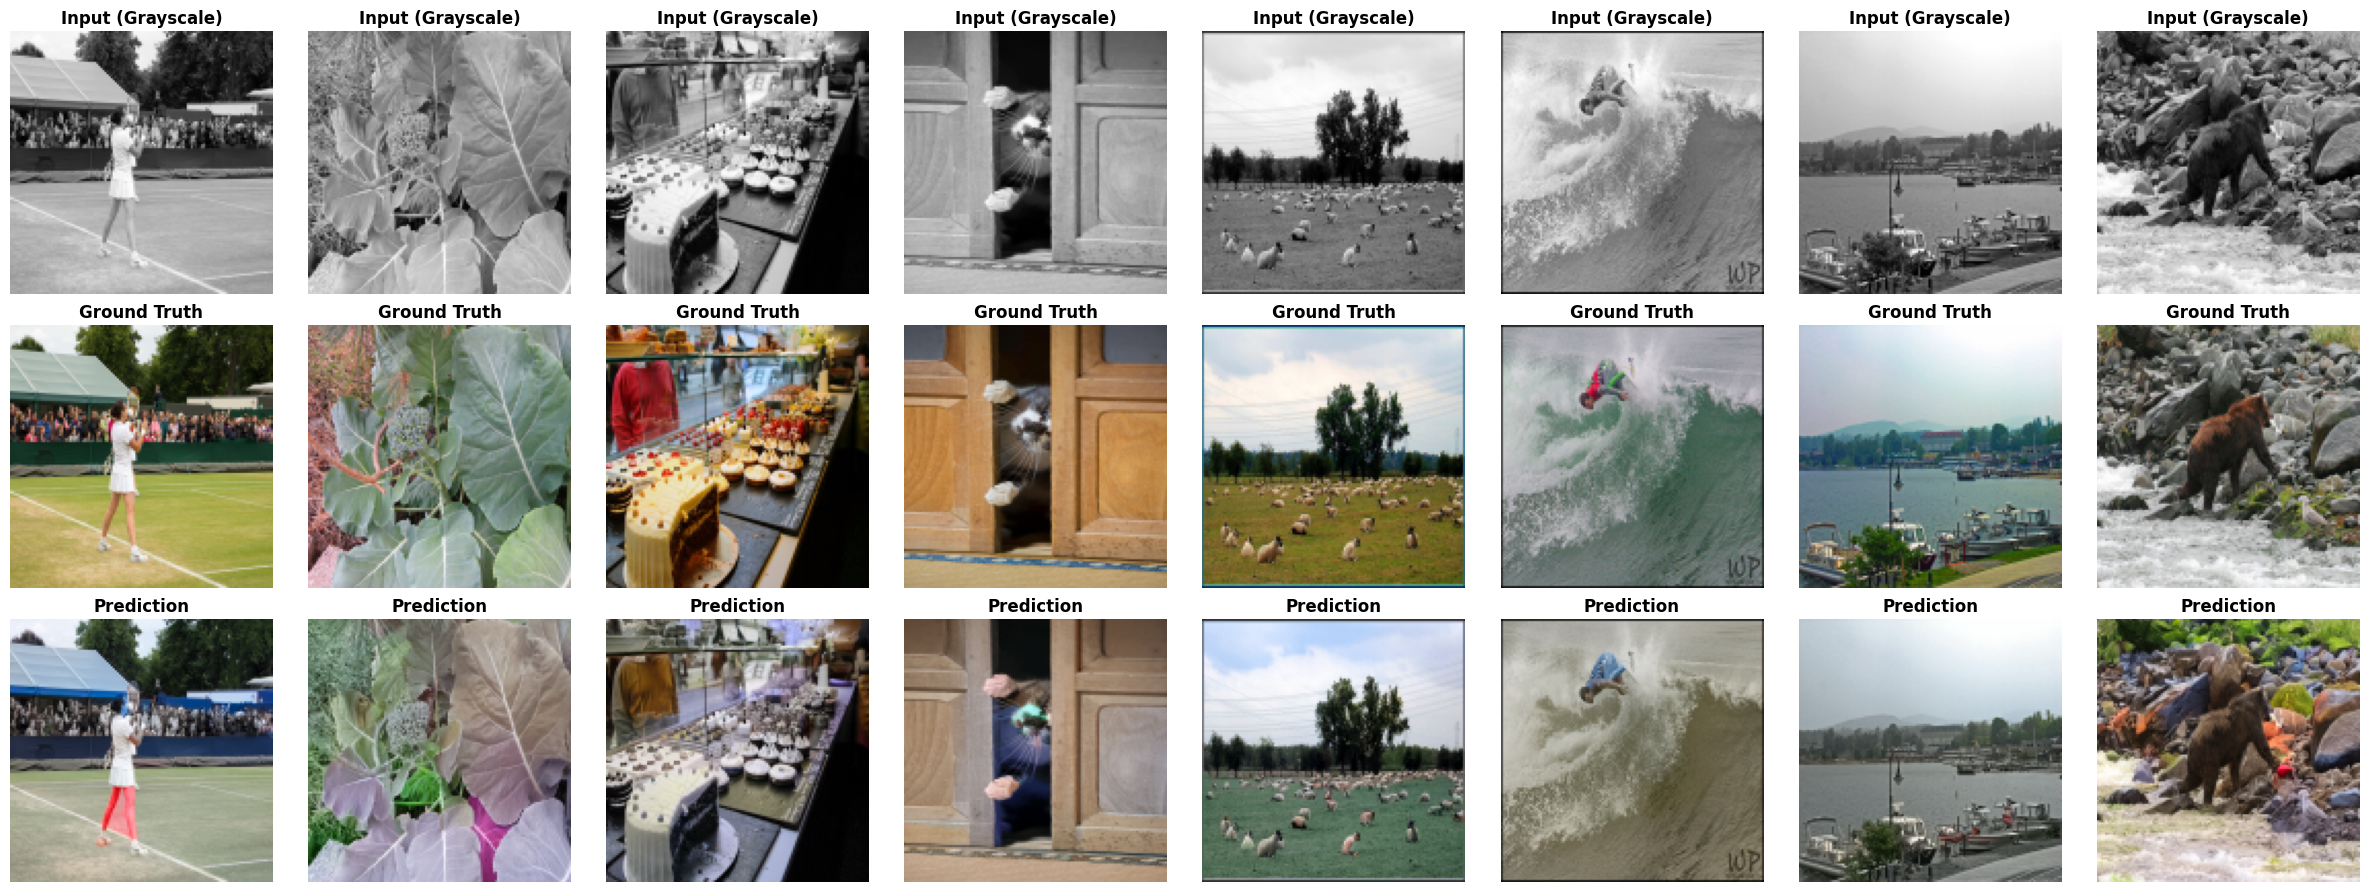

In [9]:
# Move to CPU for visualization
L_batch_cpu = L_batch.cpu()
AB_batch_gt_cpu = AB_batch_gt.cpu()
predicted_AB_cpu = predicted_AB.cpu()

# Function to convert LAB to RGB
def lab_to_rgb(L, AB):
    """
    Convert LAB tensors to RGB numpy array.
    
    Args:
        L: (C, H, W) tensor in range [0, 1]
        AB: (C, H, W) tensor in range [-1, 1]
    
    Returns:
        RGB image (H, W, 3) in range [0, 1]
    """
    # Concatenate L and AB
    lab = torch.cat([L, AB], dim=0)  # (3, H, W)
    lab = lab.permute(1, 2, 0).numpy()  # (H, W, 3)
    
    # Denormalize: L: [0,1]->[ 0,100], AB: [-1,1]->[-128,128]
    lab = np.stack([
        lab[:, :, 0] * 100,
        lab[:, :, 1] * 128,
        lab[:, :, 2] * 128
    ], axis=-1)
    
    # Convert to RGB
    rgb = lab2rgb(lab)
    return np.clip(rgb, 0, 1)

# Display results
num_display = min(8, NUM_SAMPLES)
fig, axes = plt.subplots(3, num_display, figsize=(num_display * 3, 9))

for i in range(num_display):
    # Grayscale input
    L_gray = L_batch_cpu[i, 0].numpy()
    axes[0, i].imshow(L_gray, cmap='gray')
    axes[0, i].set_title('Input (Grayscale)', fontweight='bold')
    axes[0, i].axis('off')

    # Ground truth
    rgb_gt = lab_to_rgb(L_batch_cpu[i], AB_batch_gt_cpu[i])
    axes[1, i].imshow(rgb_gt)
    axes[1, i].set_title('Ground Truth', fontweight='bold')
    axes[1, i].axis('off')

    # Prediction
    rgb_pred = lab_to_rgb(L_batch_cpu[i], predicted_AB_cpu[i])
    axes[2, i].imshow(rgb_pred)
    axes[2, i].set_title('Prediction', fontweight='bold')
    axes[2, i].axis('off')

plt.tight_layout()
output_path = os.path.join(OUTPUT_DIR, 'inference_results.png')
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved results to {output_path}")
plt.show()

## 📈 Step 9: Compute Metrics

In [10]:
print("Computing metrics...")

# Compute statistics
with torch.no_grad():
    # Ground truth statistics
    gt_mean_a = AB_batch_gt_cpu[:, 0].mean().item()
    gt_mean_b = AB_batch_gt_cpu[:, 1].mean().item()
    gt_std_a = AB_batch_gt_cpu[:, 0].std().item()
    gt_std_b = AB_batch_gt_cpu[:, 1].std().item()
    
    # Prediction statistics
    pred_mean_a = predicted_AB_cpu[:, 0].mean().item()
    pred_mean_b = predicted_AB_cpu[:, 1].mean().item()
    pred_std_a = predicted_AB_cpu[:, 0].std().item()
    pred_std_b = predicted_AB_cpu[:, 1].std().item()
    
    # MSE between prediction and ground truth
    mse = ((predicted_AB_cpu - AB_batch_gt_cpu) ** 2).mean().item()

print("\n" + "=" * 70)
print("📊 INFERENCE METRICS")
print("=" * 70)
print(f"\nGround Truth:")
print(f"  A channel: mean = {gt_mean_a:+.3f}, std = {gt_std_a:.3f}")
print(f"  B channel: mean = {gt_mean_b:+.3f}, std = {gt_std_b:.3f}")
print(f"\nPrediction:")
print(f"  A channel: mean = {pred_mean_a:+.3f}, std = {pred_std_a:.3f}")
print(f"  B channel: mean = {pred_mean_b:+.3f}, std = {pred_std_b:.3f}")
print(f"\nError:")
print(f"  MSE (AB channels): {mse:.4f}")
print(f"\nSaturation (std ratio):")
print(f"  A channel: {pred_std_a / gt_std_a * 100:.1f}%")
print(f"  B channel: {pred_std_b / gt_std_b * 100:.1f}%")
print("=" * 70)

Computing metrics...

📊 INFERENCE METRICS

Ground Truth:
  A channel: mean = -0.009, std = 0.087
  B channel: mean = +0.076, std = 0.137

Prediction:
  A channel: mean = +0.007, std = 0.064
  B channel: mean = +0.047, std = 0.115

Error:
  MSE (AB channels): 0.0163

Saturation (std ratio):
  A channel: 72.8%
  B channel: 84.0%


## 💾 Step 10: Save Individual Results (Optional)

In [11]:
# Save individual images
print("Saving individual results...")

for i in range(NUM_SAMPLES):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Grayscale
    L_gray = L_batch_cpu[i, 0].numpy()
    axes[0].imshow(L_gray, cmap='gray')
    axes[0].set_title('Input', fontweight='bold')
    axes[0].axis('off')
    
    # Ground truth
    rgb_gt = lab_to_rgb(L_batch_cpu[i], AB_batch_gt_cpu[i])
    axes[1].imshow(rgb_gt)
    axes[1].set_title('Ground Truth', fontweight='bold')
    axes[1].axis('off')
    
    # Prediction
    rgb_pred = lab_to_rgb(L_batch_cpu[i], predicted_AB_cpu[i])
    axes[2].imshow(rgb_pred)
    axes[2].set_title('Prediction', fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    save_path = os.path.join(OUTPUT_DIR, f'result_{i+1:02d}.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

print(f"✅ Saved {NUM_SAMPLES} individual results to {OUTPUT_DIR}")

Saving individual results...
✅ Saved 50 individual results to C:\Users\HP\Desktop\Image colorization\inference_results
✅ Saved 50 individual results to C:\Users\HP\Desktop\Image colorization\inference_results


---

## 📌 Summary

### ✅ What This Notebook Does:
1. Loads trained model from checkpoint (epoch 26)
2. Loads validation images from H5 file
3. Runs pure model inference (50 denoising steps)
4. No bias correction or post-processing
5. Displays results and computes metrics
6. Saves visualizations

### 🎯 Key Parameters:
- **Inference steps**: 50 (balance between speed and quality)
- **No correction**: Pure model output
- **Clamping**: AB values clamped to [-1, 1] (standard preprocessing)

### 📊 Metrics to Check:
- **MSE**: Lower is better (typical: 0.02-0.05)
- **Std ratio**: ~100% means similar saturation to ground truth
- **Mean bias**: Close to 0 means no color cast

### 🔧 To Customize:
- Change `NUM_INFERENCE_STEPS` (25-100) for speed/quality tradeoff
- Change `NUM_SAMPLES` to process more/fewer images
- Update paths to your checkpoint and data

**🚀 Ready to use! Just update the paths and run all cells!**

## 🔍 Step 11: Upscale Results (Optional)

Upscale colorized images from 128×128 to higher resolution for better viewing quality.

Upscaling 8 images from 128×128 to 1024×1024...
✅ Saved upscaled comparison to C:\Users\HP\Desktop\Image colorization\inference_results\upscaled\upscaled_comparison.png
✅ Saved 24 individual upscaled images to C:\Users\HP\Desktop\Image colorization\inference_results\upscaled/
✅ Saved upscaled comparison to C:\Users\HP\Desktop\Image colorization\inference_results\upscaled\upscaled_comparison.png
✅ Saved 24 individual upscaled images to C:\Users\HP\Desktop\Image colorization\inference_results\upscaled/


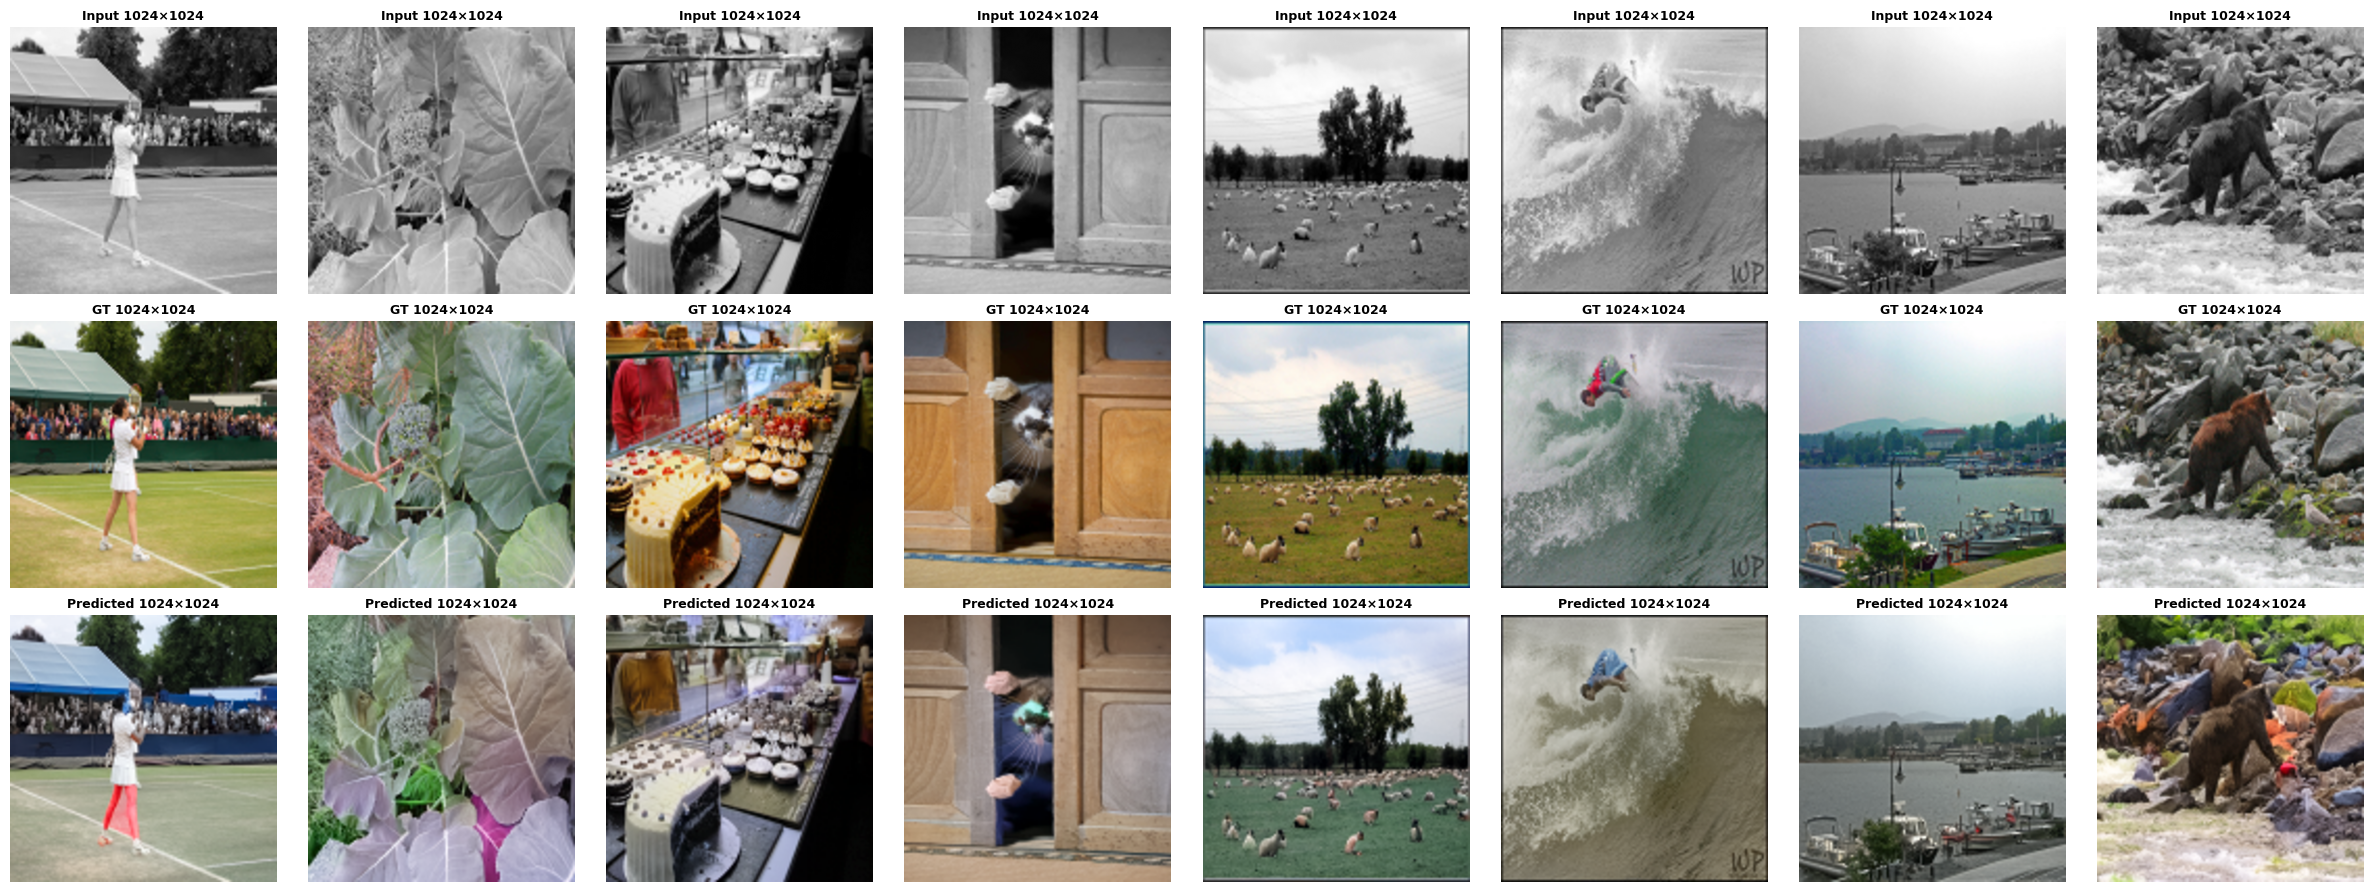


📊 Upscaling Summary:
  Original: 128×128 pixels
  Upscaled: 1024×1024 pixels (8x resolution)
  Method: Bicubic interpolation
  Sharpening: Enabled
  Output: C:\Users\HP\Desktop\Image colorization\inference_results\upscaled/


In [12]:
from PIL import Image, ImageFilter
import torchvision.transforms.functional as TF

# Configuration
UPSCALE_SIZE = 1024  # Target resolution (1024x1024)
APPLY_SHARPENING = True  # Apply light sharpening to reduce blur
NUM_UPSCALE_SAMPLES = min(8, NUM_SAMPLES)  # How many to upscale and save

print(f"Upscaling {NUM_UPSCALE_SAMPLES} images from 128×128 to {UPSCALE_SIZE}×{UPSCALE_SIZE}...")

# Create upscaled directory
upscaled_dir = os.path.join(OUTPUT_DIR, "upscaled")
os.makedirs(upscaled_dir, exist_ok=True)

def upscale_rgb_image(rgb_array, target_size=1024, sharpen=True):
    """
    Upscale RGB image with optional sharpening.
    
    Args:
        rgb_array: (H, W, 3) numpy array in [0, 1]
        target_size: Output resolution
        sharpen: Apply sharpening filter
    
    Returns:
        Upscaled PIL Image
    """
    # Convert to PIL (0-255 uint8)
    img = Image.fromarray((rgb_array * 255).astype(np.uint8))
    
    # Upscale with high-quality bicubic interpolation
    img_upscaled = img.resize((target_size, target_size), Image.BICUBIC)
    
    # Optional: Apply light sharpening to compensate for interpolation blur
    if sharpen:
        img_upscaled = img_upscaled.filter(ImageFilter.UnsharpMask(radius=1, percent=150, threshold=3))
    
    return img_upscaled

# Upscale and save results
fig, axes = plt.subplots(3, NUM_UPSCALE_SAMPLES, figsize=(NUM_UPSCALE_SAMPLES * 3, 9))

for i in range(NUM_UPSCALE_SAMPLES):
    # Convert LAB to RGB (128×128)
    rgb_gt_small = lab_to_rgb(L_batch_cpu[i], AB_batch_gt_cpu[i])
    rgb_pred_small = lab_to_rgb(L_batch_cpu[i], predicted_AB_cpu[i])
    
    # Grayscale upscaled
    L_gray = L_batch_cpu[i, 0].numpy()
    L_upscaled = Image.fromarray((L_gray * 255).astype(np.uint8), mode='L')
    L_upscaled = L_upscaled.resize((UPSCALE_SIZE, UPSCALE_SIZE), Image.BICUBIC)
    
    axes[0, i].imshow(np.array(L_upscaled), cmap='gray')
    axes[0, i].set_title(f'Input {UPSCALE_SIZE}×{UPSCALE_SIZE}', fontweight='bold', fontsize=9)
    axes[0, i].axis('off')
    
    # Ground truth upscaled
    gt_upscaled = upscale_rgb_image(rgb_gt_small, UPSCALE_SIZE, APPLY_SHARPENING)
    axes[1, i].imshow(gt_upscaled)
    axes[1, i].set_title(f'GT {UPSCALE_SIZE}×{UPSCALE_SIZE}', fontweight='bold', fontsize=9)
    axes[1, i].axis('off')
    
    # Prediction upscaled
    pred_upscaled = upscale_rgb_image(rgb_pred_small, UPSCALE_SIZE, APPLY_SHARPENING)
    axes[2, i].imshow(pred_upscaled)
    axes[2, i].set_title(f'Predicted {UPSCALE_SIZE}×{UPSCALE_SIZE}', fontweight='bold', fontsize=9)
    axes[2, i].axis('off')
    
    # Save individual upscaled images
    L_upscaled.save(os.path.join(upscaled_dir, f'upscaled_{i+1:02d}_input.png'))
    gt_upscaled.save(os.path.join(upscaled_dir, f'upscaled_{i+1:02d}_groundtruth.png'))
    pred_upscaled.save(os.path.join(upscaled_dir, f'upscaled_{i+1:02d}_prediction.png'))

plt.tight_layout()
comparison_path = os.path.join(upscaled_dir, 'upscaled_comparison.png')
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
print(f"✅ Saved upscaled comparison to {comparison_path}")
print(f"✅ Saved {NUM_UPSCALE_SAMPLES * 3} individual upscaled images to {upscaled_dir}/")
plt.show()

print(f"\n{'='*70}")
print(f"📊 Upscaling Summary:")
print(f"  Original: 128×128 pixels")
print(f"  Upscaled: {UPSCALE_SIZE}×{UPSCALE_SIZE} pixels (8x resolution)")
print(f"  Method: Bicubic interpolation")
print(f"  Sharpening: {'Enabled' if APPLY_SHARPENING else 'Disabled'}")
print(f"  Output: {upscaled_dir}/")
print(f"{'='*70}")